In [1]:
import warnings 
warnings.filterwarnings('ignore')

import torch
import pandas as pd

#!pip install albumentations==0.4.6
import albumentations as A
from albumentations.pytorch import ToTensorV2

from dataloader import CustomDataLoader

from utils import label_accuracy_score, add_hist

import numpy as np
from tqdm import tqdm

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.patches import Patch

import random

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))

# print(torch.cuda.get_device_name(0))
# print(torch.cuda.device_count())

# GPU 사용 가능 여부에 따라 device 정보 저장
device = "cuda" if torch.cuda.is_available() else "cpu"

import segmentation_models_pytorch as smp

pytorch version: 1.7.1
GPU 사용 가능 여부: True


In [2]:
# seed 고정
random_seed = 21
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [3]:
category_names = ['Backgroud', 'General trash', 'Paper', 'Paper pack', 'Metal', 'Glass', 'Plastic', 'Styrofoam', 'Plastic bag', 'Battery', 'Clothing']

In [4]:
def validation(model, data_loader, device):
    print(f'Start validation')
    model.eval()

    with torch.no_grad():
        n_class = 11
        total_loss = 0
        cnt = 0
        
        hist = np.zeros((n_class, n_class))
        with tqdm(total=len(data_loader)) as pbar:
            pbar.set_description(f"[Validation]")
            for step, (images, masks, _) in enumerate(data_loader):
                
                images = torch.stack(images)       
                masks = torch.stack(masks).long()  

                images, masks = images.to(device), masks.to(device)            
                
                # device 할당
                model = model.to(device)
                
                outputs = model(images)
                # loss = criterion(outputs, masks)
                # total_loss += loss
                cnt += 1
                
                pbar.update(1)
                
                outputs = torch.argmax(outputs, dim=1).detach().cpu().numpy()
                masks = masks.detach().cpu().numpy()
                
                hist = add_hist(hist, masks, outputs, n_class=n_class)
        
        acc, acc_cls, mIoU, fwavacc, IoU = label_accuracy_score(hist)
        IoU_by_class = [{classes : round(IoU,4)} for IoU, classes in zip(IoU , category_names)]
        
        # avrg_loss = total_loss / cnt
        print(f'Validation \nAccuracy : {round(acc, 4)}, \tmIoU: {round(mIoU, 4)}')
        print(f'IoU by class : \n{IoU_by_class}')

        for d in IoU_by_class:
            cls = list(d.keys())[0]
            iou = list(d.values())[0]

        
    return mIoU, IoU_by_class

In [5]:
batch_size = 8   # Mini-batch size

In [6]:
# train.json / validation.json / test.json 디렉토리 설정
dataset_path  = '../../data'
train_path = dataset_path + '/train.json'
val_path = dataset_path + '/val.json'

In [7]:
val_transform = A.Compose([
                          ToTensorV2()
                          ])

                        
val_dataset = CustomDataLoader(data_dir=val_path, mode='val', transform=val_transform)

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=4,
                                         collate_fn=collate_fn)

loading annotations into memory...
Done (t=1.08s)
creating index...
index created!


In [26]:

import segmentation_models_pytorch as smp
from models import build

build.register_encoder()

# model 불러오기
# 출력 label 수 정의 (classes=11)

model = smp.PAN(
			encoder_name="swin_encoder",
			encoder_weights="imagenet",
            encoder_output_stride=32,
			in_channels=3,
			classes=11
)

# best model 저장된 경로
model_name = 'SMP_PAN_SwinL_StepLR_AUGMANY_best_model(pretrained)'
model_path = f'./saved/{model_name}.pt'     # 모델 바꿔주세요

# best model 불러오기
checkpoint = torch.load(model_path, map_location=device)
state_dict = checkpoint.state_dict()
model.load_state_dict(state_dict)

model = model.to(device)

In [27]:
mIoU, IoU_by_class = validation(model, val_loader, device)

[Validation]:   0%|          | 0/82 [00:00<?, ?it/s]

Start validation


[Validation]: 100%|██████████| 82/82 [00:43<00:00,  1.88it/s]

Validation 
Accuracy : 0.9446, 	mIoU: 0.711
IoU by class : 
[{'Backgroud': 0.9627}, {'General trash': 0.4751}, {'Paper': 0.8056}, {'Paper pack': 0.6695}, {'Metal': 0.6928}, {'Glass': 0.6893}, {'Plastic': 0.5571}, {'Styrofoam': 0.7675}, {'Plastic bag': 0.8415}, {'Battery': 0.674}, {'Clothing': 0.6858}]


In [28]:
cat_names = []
ious = []
for d in IoU_by_class:
    cls = list(d.keys())[0]
    iou = list(d.values())[0]
    cat_names.append(cls)
    ious.append(iou)
print(cat_names)
print(ious)

['Backgroud', 'General trash', 'Paper', 'Paper pack', 'Metal', 'Glass', 'Plastic', 'Styrofoam', 'Plastic bag', 'Battery', 'Clothing']
[0.9627, 0.4751, 0.8056, 0.6695, 0.6928, 0.6893, 0.5571, 0.7675, 0.8415, 0.674, 0.6858]


In [68]:
# Convert to DataFrame
df = pd.DataFrame({'Classes': cat_names, 'IoU': ious})
df

,Classes,IoU
0,Backgroud,0.9627
1,General trash,0.4751
2,Paper,0.8056
3,Paper pack,0.6695
4,Metal,0.6928
5,Glass,0.6893
6,Plastic,0.5571
7,Styrofoam,0.7675
8,Plastic bag,0.8415
9,Battery,0.6740


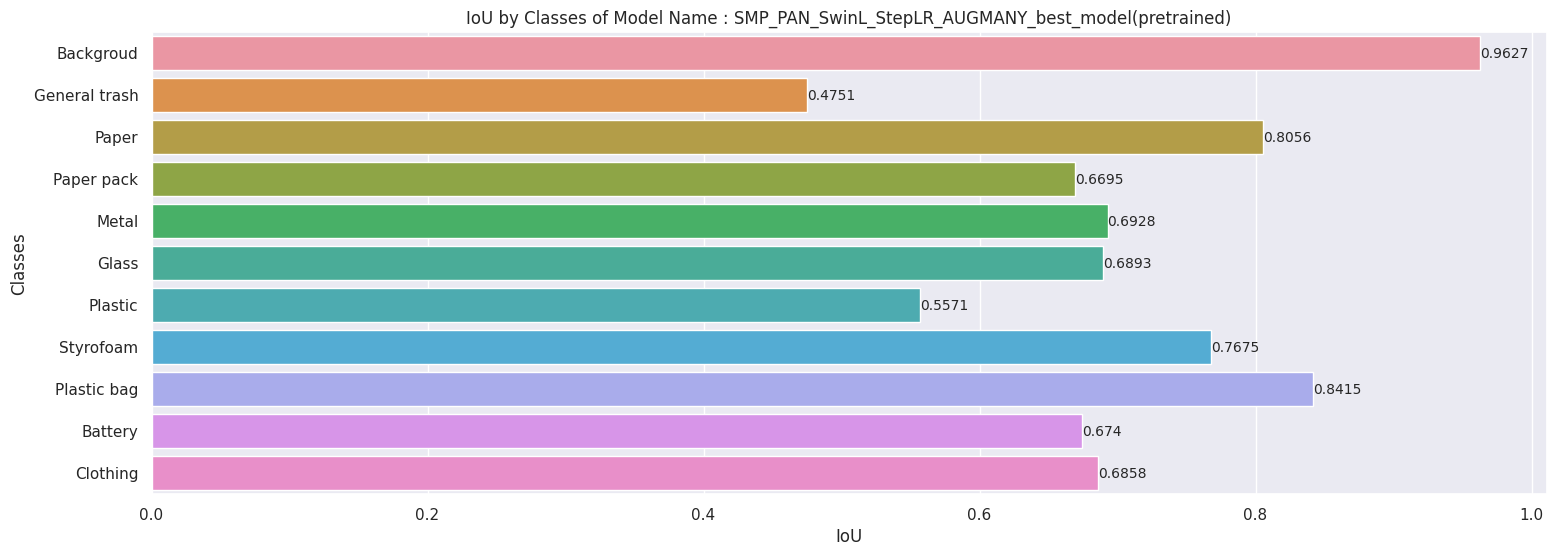

In [69]:

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(18,6))

# Plot the histogram
plt.title(f"IoU by Classes of Model Name : {model_name}")
# plt.
plot_1 = sns.barplot(x="IoU", y="Classes", data=df)
ax = plot_1
i=0
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    ax.text(width, i+0.1, width, ha = 'left', size = 10)
    i+=1


In [70]:
torch.cuda.empty_cache()